In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import random
import numpy as np
import pandas as pd
from sklearn import datasets, svm, cross_validation, tree, preprocessing, metrics
import sklearn.ensemble as ske
#import tensorflow as tf
#from tensorflow.contrib import skflow

In [2]:
titanic_df = pd.read_excel('titanic3.xls', 'titanic3', index_col=None, na_values=['NA'])

In [3]:
titanic_df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [4]:
titanic_df['survived'].mean()

0.3819709702062643

In [5]:
titanic_df.groupby('pclass').mean()

,survived,age,sibsp,parch,fare,body
pclass,,,,,,
1,0.619195,39.159918,0.436533,0.365325,87.508992,162.828571
2,0.429603,29.506705,0.393502,0.368231,21.179196,167.387097
3,0.255289,24.816367,0.568406,0.400564,13.302889,155.818182


In [6]:
class_sex_grouping = titanic_df.groupby(['pclass','sex']).mean()
class_sex_grouping

survived        age     sibsp     parch        fare        body
pclass sex                                                                    
1      female  0.965278  37.037594  0.555556  0.472222  109.412385         NaN
       male    0.340782  41.029250  0.340782  0.279330   69.888385  162.828571
2      female  0.886792  27.499191  0.500000  0.650943   23.234827   52.000000
       male    0.146199  30.815401  0.327485  0.192982   19.904946  171.233333
3      female  0.490741  22.185307  0.791667  0.731481   15.324250  183.000000
       male    0.152130  25.962273  0.470588  0.255578   12.415462  151.854167

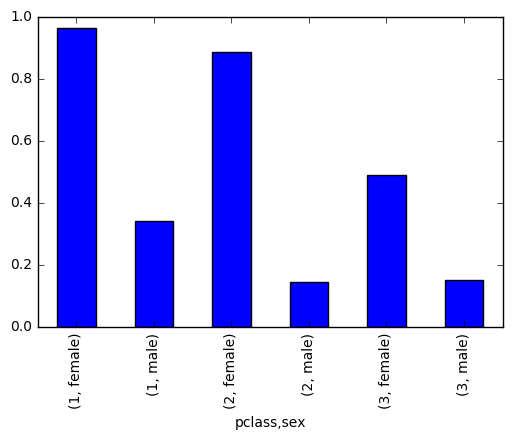

In [7]:
class_sex_grouping['survived'].plot.bar()

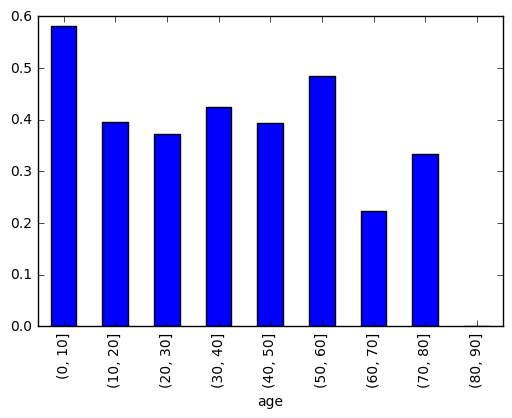

In [8]:
group_by_age = pd.cut(titanic_df['age'],np.arange(0,98,10))
age_grouping = titanic_df.groupby(group_by_age).mean()
age_grouping['survived'].plot.bar()

In [9]:
titanic_df.count()

pclass       1309
survived     1309
name         1309
sex          1309
age          1046
sibsp        1309
parch        1309
ticket       1309
fare         1308
cabin         295
embarked     1307
boat          486
body          121
home.dest     745
dtype: int64

In [10]:
titanic_df = titanic_df.drop(['body','cabin','boat'], axis = 1)
titanic_df['home.dest'] = titanic_df['home.dest'].fillna("NA")
titanic_df = titanic_df.dropna()
titanic_df.count()

pclass       1043
survived     1043
name         1043
sex          1043
age          1043
sibsp        1043
parch        1043
ticket       1043
fare         1043
embarked     1043
home.dest    1043
dtype: int64

In [11]:
# Data preprocessing
def preprocess_titanic_df(df):
    processed_df = df.copy()
    le = preprocessing.LabelEncoder()
    processed_df.sex = le.fit_transform(processed_df.sex)
    processed_df.embarked = le.fit_transform(processed_df.embarked)
    processed_df = processed_df.drop(['name','ticket','home.dest'],axis=1)
    return processed_df

processed_df = preprocess_titanic_df(titanic_df)

In [12]:
X = processed_df.drop(['survived'], axis = 1).values
y = processed_df['survived'].values

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X,y, test_size = 0.2 )

In [13]:
clf_dt = tree.DecisionTreeClassifier(max_depth=10)

clf_dt.fit(X_train, y_train)
clf_dt.score(X_test,y_test)

0.79425837320574166

In [14]:
# Use shuffle split to iterate through independent train/test dataset splits
shuffle_validator = cross_validation.ShuffleSplit(len(X), n_iter=20, test_size = 0.2, random_state=0)
def test_classifier(clf):
    scores = cross_validation.cross_val_score(clf,X,y,cv=shuffle_validator)
    print('Accuracy: %0.4f (+/- %0.2f)' %(scores.mean(), scores.std()))
    
test_classifier(clf_dt)

Accuracy: 0.7734 (+/- 0.02)


In [16]:
# Train classifiers and run through shuffle validator
clf_rf = ske.RandomForestClassifier(n_estimators=50)
test_classifier(clf_rf)

clf_gb = ske.GradientBoostingClassifier(n_estimators=50)
test_classifier(clf_gb)

eclf = ske.VotingClassifier([('dt', clf_dt), ('rf', clf_rf), ('gb', clf_gb)])
test_classifier(eclf)

Accuracy: 0.7799 (+/- 0.02)
Accuracy: 0.8201 (+/- 0.02)
Accuracy: 0.8069 (+/- 0.02)


In [24]:
# Create new training and test set/ train Gradient boosting algorithm
passengers_set_1 = titanic_df[titanic_df.pclass == 1].iloc[:20,:].copy()
passengers_set_2 = titanic_df[titanic_df.pclass == 2].iloc[:20,:].copy()
passengers_set_3 = titanic_df[titanic_df.pclass == 3].iloc[:20,:].copy()
passenger_set = pd.concat([passengers_set_1, passengers_set_2, passengers_set_3])
testing_set = preprocess_titanic_df(passenger_set)

training_set = pd.concat([titanic_df, passenger_set]).drop_duplicates(keep=False)
training_set = preprocess_titanic_df(training_set)

X_train = training_set.drop(['survived'], axis=1).values
y_train = training_set['survived'].values
X_test = testing_set.drop(['survived'], axis=1).values
y_test = testing_set['survived'].values

clf_dt_final = tree.DecisionTreeClassifier(max_depth=10)
clf_gb_final = ske.GradientBoostingClassifier(n_estimators=50)


clf_gb_final.fit(X_train, y_train)
clf_gb_final.score(X_test,y_test)

0.81666666666666665

In [23]:
#Look at passengers that were incorrectly classified
prediction = clf_gb_final.predict(X_test)
passenger_set[passenger_set.survived != prediction]

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,embarked,home.dest
2,1,0,"Allison, Miss. Helen Loraine",female,2.0,1,2,113781,151.5500,S,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0,1,2,113781,151.5500,S,"Montreal, PQ / Chesterville, ON"
5,1,1,"Anderson, Mr. Harry",male,48.0,0,0,19952,26.5500,S,"New York, NY"
14,1,1,"Barkworth, Mr. Algernon Henry Wilson",male,80.0,0,0,27042,30.0000,S,"Hessle, Yorks"
20,1,1,"Beckwith, Mr. Richard Leonard",male,37.0,1,1,11751,52.5542,S,"New York, NY"
336,2,1,"Beane, Mr. Edward",male,32.0,1,0,2908,26.0000,S,"Norwich / New York, NY"
603,3,1,"Abbott, Mrs. Stanton (Rosa Hunt)",female,35.0,1,1,C.A. 2673,20.2500,S,"East Providence, RI"
605,3,1,"Abelseth, Mr. Olaus Jorgensen",male,25.0,0,0,348122,7.6500,S,"Perkins County, SD"
606,3,1,"Abrahamsson, Mr. Abraham August Johannes",male,20.0,0,0,SOTON/O2 3101284,7.9250,S,"Taalintehdas, Finland Hoboken, NJ"
612,3,1,"Aks, Mrs. Sam (Leah Rosen)",female,18.0,0,1,392091,9.3500,S,"London, England Norfolk, VA"
